In [11]:
from src.memory_game.game import Game
from src.wm.wm import WorkingMemory
from src.wm.agent import Agent

from fiftyone import ViewField as F

import math

import torch

import pandas as pd

import numpy as np

import collections, gc, resource

from tqdm import tqdm

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
sns.set_style(style='white')

torch.no_grad()

In [12]:
print(f'Cuda available: {torch.cuda.is_available()}')
print(f'Cuda device count: {torch.cuda.device_count()}')

Cuda available: True
Cuda device count: 4


In [13]:
device = 1

device = torch.device(f"cuda:{device}")
print(torch.cuda.get_device_name(device))

GeForce RTX 2080 Ti


# Collect data 1 Trial

In [14]:
def play_strategy(strategy, game, max_steps):
    win = False
    steps = 0
    pos = []
    while not win and steps < max_steps:
        #print(f'pick')
        pos.append(strategy.pick())
        #print(p)
        win, tot = game.check_win()
        torch.cuda.empty_cache()
        steps+=1
    return tot, pos

In [15]:
def plot_history(locations, category, c, t_steps, events, events_dict):
    # create a 3 X 2 grid 
    fig = plt.figure(figsize=(36, 10))
    gs = grd.GridSpec(3, 2, figure=fig, height_ratios=[len(locations),len(locations),len(category)], width_ratios=[18,1], wspace=0.4)
    # image plot
    ax1 = plt.subplot(gs[1,0])
    p1 = ax1.imshow(locations, aspect='auto', interpolation='none', cmap='hot')
    colorAx1 = plt.subplot(gs[1,1])
    cb1 = plt.colorbar(p1, cax = colorAx1)
    # image plot
    ax2 = plt.subplot(gs[2,0])
    p2 = ax2.imshow(category, aspect='auto', interpolation='none', cmap='hot')
    colorAx2 = plt.subplot(gs[2,1])
    cb2 = plt.colorbar(p2, cax = colorAx2)
    # plot
    ax3 = plt.subplot(gs[0,0])
    for i, ci in enumerate(c.T):
        ax3.plot(range(len(ci)), ci, label = f"{i}")
    ax3.autoscale(enable=True, axis='x', tight=True)
    for t,e in zip(t_steps, events):
        ax3.axvline(x=t, color=events_dict[e], linestyle='--')
    # plot legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label)
                    for label, color in events_dict.items()]
    ax4 = plt.subplot(gs[0,1])
    ax4.legend(handles=legend_elements)
    ax4.axis('off')
    
    plt.show()

In [16]:
game = Game(
            dataset_name='coco-2017', 
            split='validation', 
            field="ground_truth", 
            ds_filter=F("supercategory").is_in(('person', 'animal', 'food', 'vehicle', 'indoor')),
            dataset_dir ="/home/ravi/datasets/coco-2017",
        )

Found annotations at '/home/ravi/datasets/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


[0 3 1 1 2 4 2 0 4]
[0 1 2 3 4 5 6 7 8]
[0, 1, 2, 0, 8, 0]


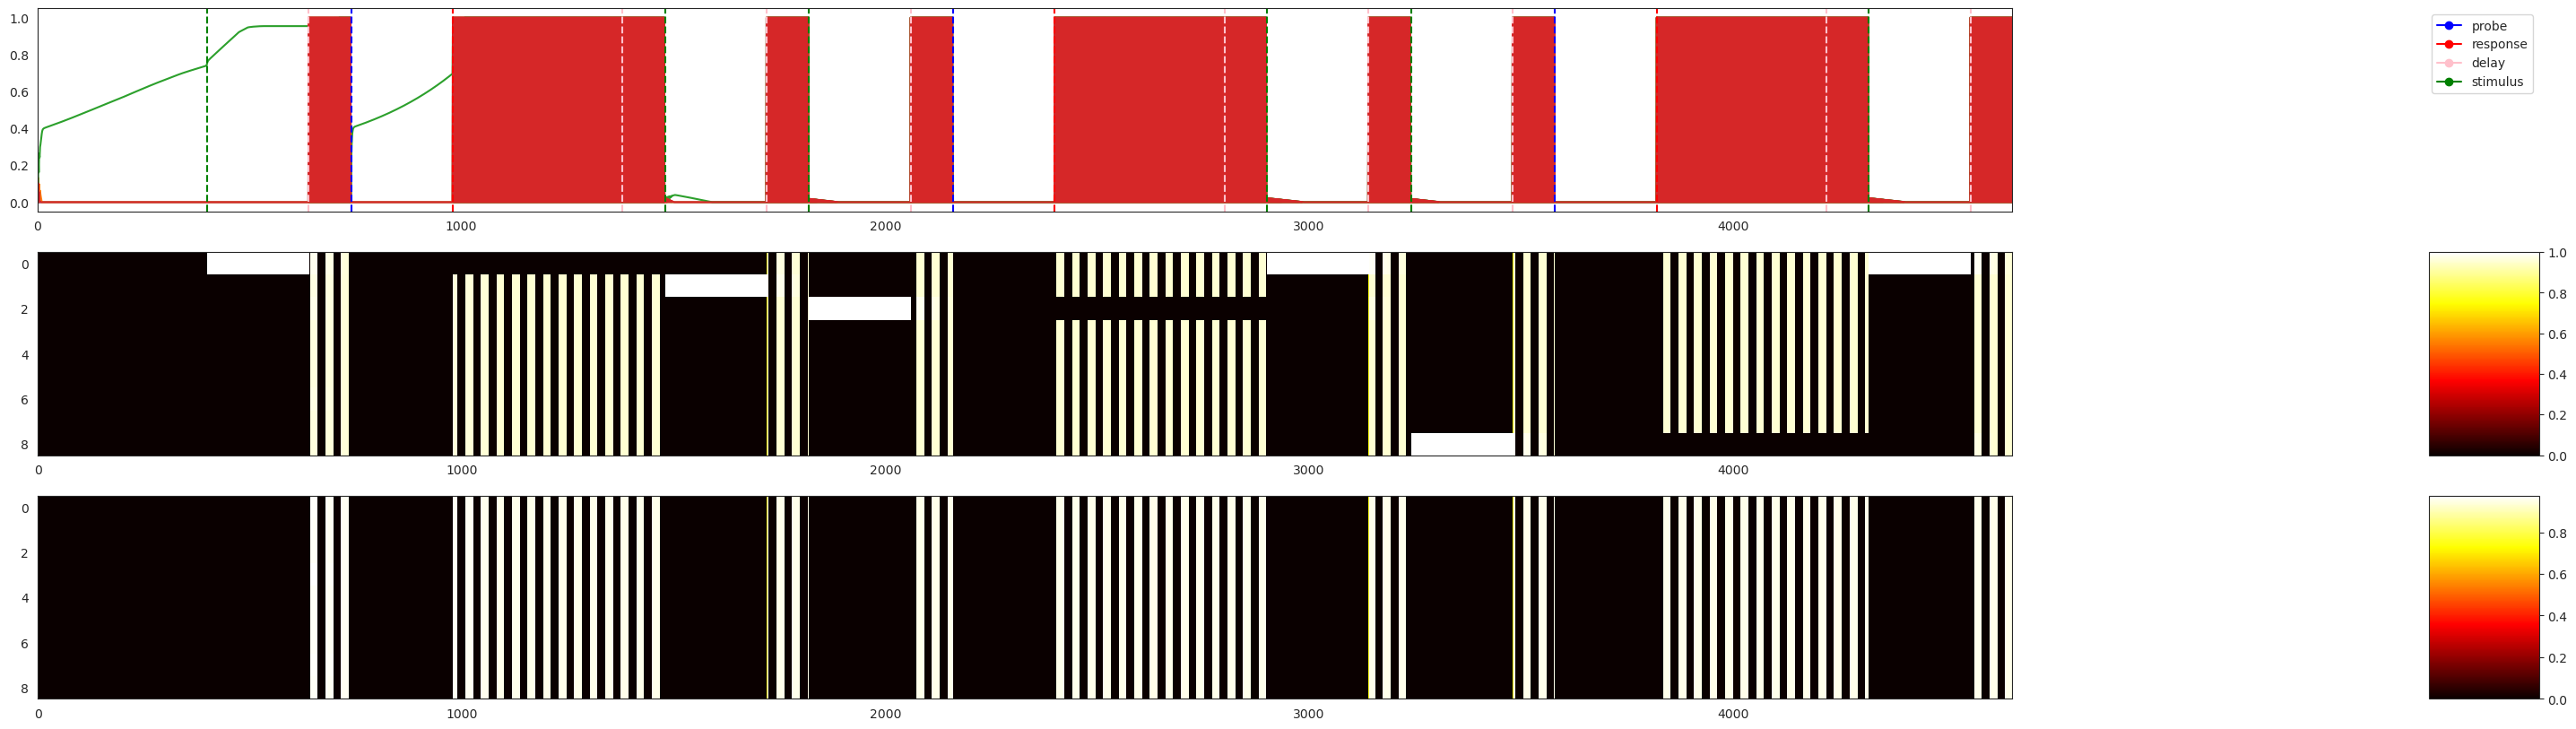

In [18]:
game.set_size([3,3])
n_features = 50
memory = WorkingMemory([n_features // 2, n_features // 2], 4, [-0.5, 1.0, 1.2/n_features, -0.2/n_features, 0.99, 0.96/n_features], 0.2, 0.0, 0.02, 0.02)
strategy = Agent(game, memory, response_steps=200)
print(game.get_grid_labels())
print(np.arange(9))
_, pos = play_strategy(strategy, game, max_steps=6)
print(pos)
f, c, _ = memory.get_activation_history()
events_dict = {'probe': 'blue', 'response': 'red', 'delay': 'pink', 'stimulus': 'green'}
plot_history(f.T[:9], f.T[10:19], c, strategy.t_steps, strategy.events, events_dict)

In [8]:
memory.Wff.weight


Parameter containing:
tensor([[ 0.1000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [-0.2000,  0.1000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [-0.2000, -0.2000,  0.1000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [-0.2000, -0.2000, -0.2000,  0.1000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [-0.2000, -0.2000, -0.2000, -0.2000,  0.1000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0

In [9]:
memory.Wff.weight[9:,9:]

tensor([[ 0.1000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.1000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000, -0.2000],
        [ 0.0000, -0.2000,  0.1000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000, -0.2000],
        [ 0.0000, -0.2000, -0.2000,  0.1000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000, -0.2000],
        [ 0.0000, -0.2000, -0.2000, -0.2000,  0.1000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000, -0.2000],
        [ 0.0000, -0.2000, -0.2000, -0.2000, -0.2000,  0.1000, -0.2000, -0.2000,
         -0.2000, -0.2000, -0.2000],
        [ 0.0000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,  0.1000, -0.2000,
         -0.2000, -0.2000, -0.2000],
        [ 0.0000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,  0.1000,
         -0.2000, -0.2000, -0.2000],
        [ 0.0000, -0.2000, -0.2000, -0.2000, -0.2000, -0

In [10]:
y = torch.tensor([0.,0.,0.,0.,0.,0.,0.,0.,1.,0.,0.,0.,1.,0.])
memory.Wff(y)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x14 and 20x20)

## Perform tests

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
def collect_data(n_trials, size_range, game):
    data = []
    for size in size_range:
        data_size = []
        for n in tqdm(range(n_trials), desc=f'Size: {size}'):
            game.set_size(size)
            #print(game.get_grid_labels())
            f_dims = [np.prod(size), len(np.unique(game.get_grid_labels()))]
            memory = WorkingMemory(f_dims, 7, [-0.28, 1.03, 0.05, -0.2, 0.85, 0.05], 0.07, 0.0, 0.02, 0.02)
            strategy = Agent(game, memory)
            tot, _ = play_strategy(strategy, game, max_steps=10000)
            data_size.append(math.log10(tot/np.prod(size)))
        data.append(data_size)
    return data

In [ ]:
n_trials = 20

size_range = [[3,3], [4,4]] #, [5,5], [6,6], [7,7]]

In [ ]:
collected_data = collect_data(n_trials, size_range, game)

Size: [3, 3]:  10%|█         | 2/20 [00:09<01:29,  4.96s/it]


KeyboardInterrupt: 

In [ ]:
data = pd.melt(pd.DataFrame(collected_data).T, var_name='size', value_name='nclicks')
data['strategy'] = 'Attractor network'


In [ ]:
data['size']+=3
data['size'] = data['size'].astype('str')

/tmp/ipykernel_518732/4064944962.py:4: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  ax = sns.scatterplot(x="size", y='nclicks', hue="strategy", data=data, legend=False, palette=palette)


<Figure size 800x1600 with 0 Axes>

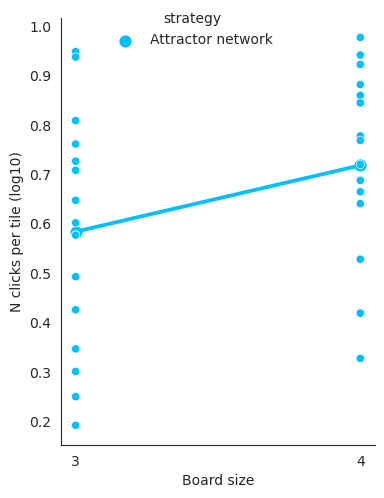

In [ ]:
plt.figure(figsize=(8, 16))
palette = ['deepskyblue', 'blue', 'plum', 'red']
ax2 = sns.catplot(x="size", y='nclicks', hue="strategy", data=data, aspect=0.85, errorbar=None, kind='point', palette=palette)
ax = sns.scatterplot(x="size", y='nclicks', hue="strategy", data=data, legend=False, palette=palette)
ax.set_xlabel("Board size")
ax.set_ylabel("N clicks per tile (log10)")
sns.move_legend(ax2, "upper center")
#plt.savefig('/home/ravi/figures/attractor.svg')